Comparing multiple runs 

Gustavo Marques (gmarques@ucar.edu)

In [1]:
from datetime import date
print("Last update:", date.today())

Last update: 2020-11-10


## Brief summary of the experiments 

* Baseline - out-of-the-box (CESM2.2/MOM6 tag) 
* LBD - Baseline + LBD

They were all run for one cycle of the JRA-55 v1.3 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn, matplotlib
import warnings, os
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import ztplot, xyplot
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

Basemap module not found. Some regional plots may not function properly


In [3]:
path = '/glade/scratch/gmarques/'
exps = ['gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001', \
        'gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.003']
labels = ['Baseline', 'LBD']

# set this to true to save the plots
saveplot = False
if saveplot:
    os.system('mkdir PNG')

In [4]:
def get_data(full_path, variables):
  def preprocess(ds):
    ''' Return the dataset with variable'''
    return ds[variables]
  ds = xr.open_mfdataset(full_path, data_vars='minimal', \
                         coords='minimal', compat='override', preprocess=preprocess)
  return ds

In [5]:
# load grid and pre-difined masks
grd = MOM6grid(path+exps[0]+'/run/'+exps[0]+'.mom6.static.nc')
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

MOM6 grid successfully loaded... 

11.16427964664149 64.78854837178643 [391, 434]


### 1.1 Globally-averaged ocean properties

/glade/scratch/gmarques/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001/run/*mom6.hm_*_01.nc
/glade/scratch/gmarques/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.003/run/*mom6.hm_*_01.nc


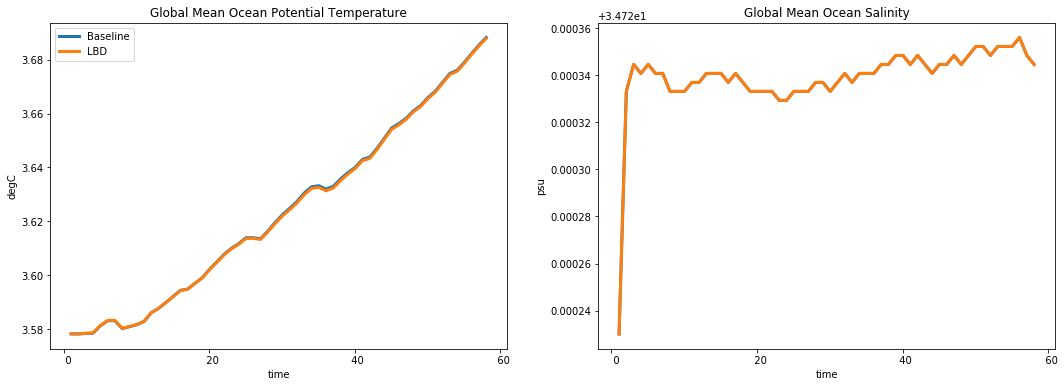

In [6]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
variables = ['thetaoga', 'soga']
for i in range(len(exps)):
  tmp = path+exps[i]+'/run/*mom6.hm_*_01.nc'
  print(tmp)
  ds = get_data(tmp,variables)
  ds['thetaoga'].plot(ax=ax[0], label=labels[i], lw=3)
  ds['soga'].plot(ax=ax[1], lw=3)

ax[0].set_title(ds.thetaoga.attrs['long_name']); ax[0].set_ylabel(ds.thetaoga.attrs['units'])
ax[1].set_title(ds.soga.attrs['long_name']); ax[1].set_ylabel(ds.soga.attrs['units'])
ax[0].legend()
if saveplot:
    fname = 'PNG/global_means.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

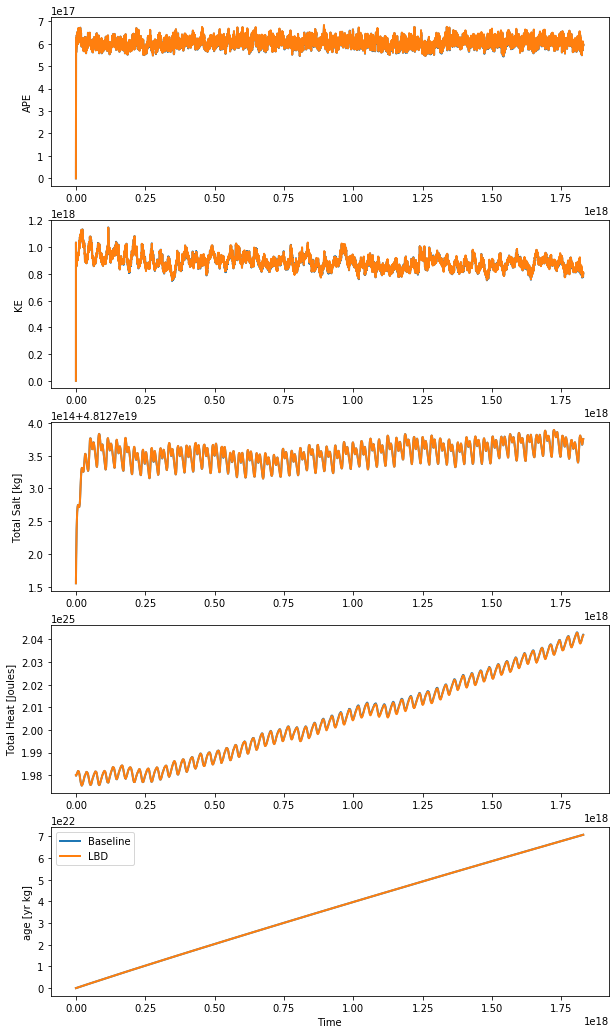

In [7]:
%matplotlib inline
variables = ['APE', 'KE', 'Salt', 'Heat', 'age']
fig, ax = plt.subplots(nrows=len(variables), ncols=1, figsize=(10,18))
for i in range(len(exps)): 
  ds = xr.open_dataset(path+exps[i]+'/run/ocean.stats.nc')
  #ds = ds.isel(Time=range(1000, 21172))
  for var, j in zip(variables, range(len(variables))):
    if len(ds[var].shape) > 1:
        tmp = ds[var].sum(axis=1)
    else:
        tmp = ds[var]
    tmp.plot(ax=ax[j], label=labels[i], lw=2)
    ax[j].set_xlabel('')
    
ax[j].set_xlabel('Time'); ax[j].legend()
if saveplot:
    fname = 'PNG/ocean_stats.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

### 1.2 Mixed layer depth

In [6]:
filepath = '/glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc'
print('\n Reading climatology from: ', filepath)
mld_obs = xr.open_dataset(filepath)
months = [0,1,2]
obs_JFM = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
months = [6,7,8]
obs_JAS = np.ma.masked_invalid(mld_obs.mld.isel(time=months).mean('time').values)
obs_winter = obs_JAS.copy(); obs_summer = obs_JAS.copy()
j = np.abs( grd.geolat[:,0] - 0. ).argmin()
obs_winter[j::,:] = obs_JFM[j::,:]
obs_summer[0:j,:] = obs_JFM[0:j,:]

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
def add_labels(ax, nh='JFM', sh='JAS'):
    ax.plot([grd.geolon[0,0], grd.geolon[0,-1]], [0,0], 'k--', lw=0.5)
    ax.text(25, 7, nh, ha="center", va="center", size=12, bbox=bbox_props)
    ax.text(25, -7, sh, ha="center", va="center", size=12, bbox=bbox_props)


 Reading climatology from:  /glade/work/gmarques/cesm/datasets/MLD/deBoyer/deBoyer_MLD_remapped_to_tx06v1.nc


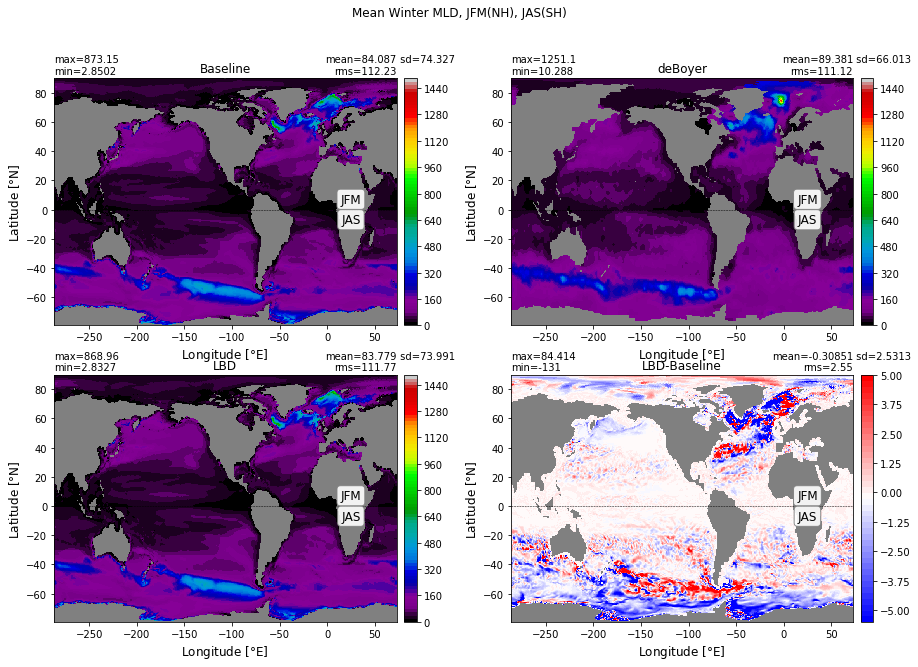

In [18]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax1 = ax.flatten()
plt.suptitle('Mean Winter MLD, JFM(NH), JAS(SH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_winter.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_winter.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,1500), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_winter.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,1500),
         colormap=plt.cm.nipy_spectral, nbins=100); add_labels(ax1[i+1])


xyplot(obs_winter, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,1500), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1])

diff = var - control
xyplot(diff, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]) +'-' +str(labels[0]), axis=ax1[-1], 
       colormap=plt.cm.bwr, nbins=50); add_labels(ax1[-1])

if saveplot:
    fname = 'PNG/MLD_winter.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

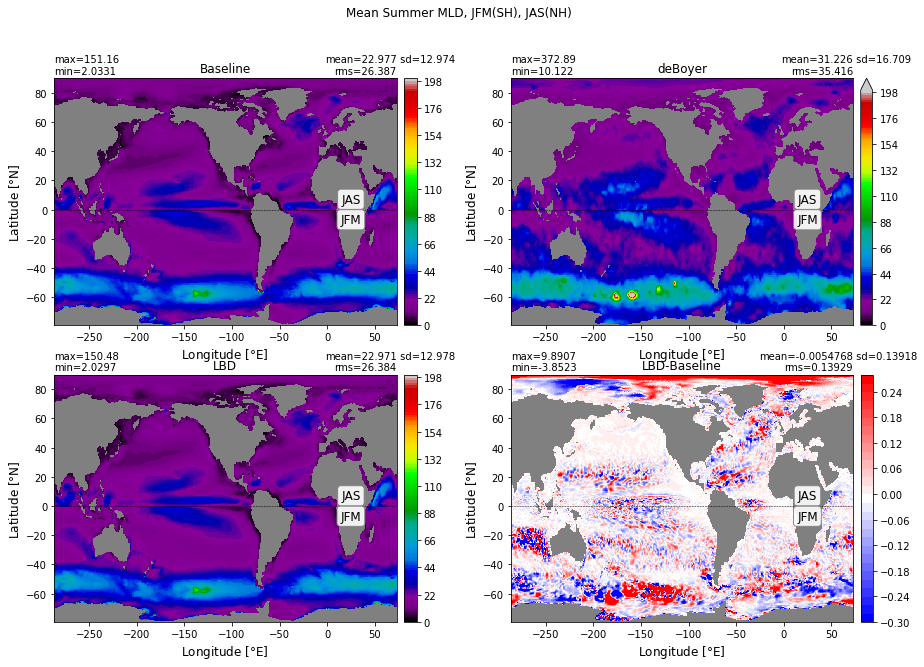

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   control = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(control, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i], sh='JFM', nh='JAS')
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) 
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i+1], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral); add_labels(ax1[i+1], sh='JFM', nh='JAS')

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral); add_labels(ax1[1], sh='JFM', nh='JAS')

diff = var - control
xyplot(diff, grd.geolon, grd.geolat, grd.area_t, title=str(labels[1]) +'-' +str(labels[0]), axis=ax1[-1], 
       colormap=plt.cm.bwr, nbins=50); add_labels(ax1[-1], sh='JFM', nh='JAS')

if saveplot:
    fname = 'PNG/MLD_summer.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
ax1 = ax.flatten()
plt.suptitle('Mean Summer MLD, JFM(SH), JAS(NH)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MLD_summer.nc')
  if i == 0:
   C = np.ma.masked_invalid(ds.MLD_summer.values)
   xyplot(C, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]), axis=ax1[i], clim=(0,200), nbins=100,
         colormap=plt.cm.nipy_spectral, extend='neither',); add_labels(ax1[i])
  else:
   var = np.ma.masked_invalid(ds.MLD_summer.values) - C
   xyplot(var, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]) + '-' + str(labels[0]), 
          axis=ax1[i+1], clim=(-10,10),
         colormap=plt.cm.bwr, extend='neither', centerlabels=True, nbins=50); add_labels(ax1[i+1])

xyplot(obs_summer, grd.geolon, grd.geolat, grd.area_t, title='deBoyer', axis=ax1[1], clim=(0,200), nbins=100,
       colormap=plt.cm.nipy_spectral, extend='neither',); add_labels(ax1[1])
if saveplot:
    fname = 'PNG/MLD_summer_comparison.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

###  1.3 Poleward Heat Transport

In [ ]:
def get_heat_transport_obs():
  import netCDF4
  """Plots model vs obs poleward heat transport for the global, Pacific and Atlantic basins"""
  # Load Observations
  fObs = netCDF4.Dataset('/glade/work/gmarques/cesm/datasets/Trenberth_and_Caron_Heat_Transport.nc')
  #Trenberth and Caron
  yobs = fObs.variables['ylat'][:]
  NCEP = {}; NCEP['Global'] = fObs.variables['OTn']
  NCEP['Atlantic'] = fObs.variables['ATLn'][:]; NCEP['IndoPac'] = fObs.variables['INDPACn'][:]
  ECMWF = {}; ECMWF['Global'] = fObs.variables['OTe'][:]
  ECMWF['Atlantic'] = fObs.variables['ATLe'][:]; ECMWF['IndoPac'] = fObs.variables['INDPACe'][:]

  #G and W
  Global = {}
  Global['lat'] = np.array([-30., -19., 24., 47.])
  Global['trans'] = np.array([-0.6, -0.8, 1.8, 0.6])
  Global['err'] = np.array([0.3, 0.6, 0.3, 0.1])

  Atlantic = {}
  Atlantic['lat'] = np.array([-45., -30., -19., -11., -4.5, 7.5, 24., 47.])
  Atlantic['trans'] = np.array([0.66, 0.35, 0.77, 0.9, 1., 1.26, 1.27, 0.6])
  Atlantic['err'] = np.array([0.12, 0.15, 0.2, 0.4, 0.55, 0.31, 0.15, 0.09])

  IndoPac = {}
  IndoPac['lat'] = np.array([-30., -18., 24., 47.])
  IndoPac['trans'] = np.array([-0.9, -1.6, 0.52, 0.])
  IndoPac['err'] = np.array([0.3, 0.6, 0.2, 0.05,])

  GandW = {}
  GandW['Global'] = Global
  GandW['Atlantic'] = Atlantic
  GandW['IndoPac'] = IndoPac
  return NCEP, ECMWF, GandW, yobs

NCEP, ECMWF, GandW, yobs = get_heat_transport_obs()
from mom6_tools.poleward_heat_transport import annotateObs, plotGandW, plotHeatTrans, heatTrans

In [ ]:
def get_adv_diff(ds):
  # create a ndarray subclass
  class C(np.ndarray): pass

  varName = 'T_ady_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    advective = tmp.view(C)
    advective.units = 'W'
  else:
    raise Exception('Could not find "T_ady_2d"')

  varName = 'T_diffy_2d'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds[varName].values)
    tmp = tmp[:].filled(0.)
    diffusive = tmp.view(C)
    diffusive.units = 'W'
  else:
    diffusive = None
    warnings.warn('Diffusive temperature term not found. This will result in an underestimation of the heat transport.')

  varName = 'T_lbm_diffy'
  if varName in ds.variables:
    tmp = np.ma.masked_invalid(ds_sel[varName].sum('z_l').values)
    tmp = tmp[:].filled(0.)
    diffusive = diffusive + tmp.view(C)
  else:
    warnings.warn('Lateral boundary mixing term not found. This will result in an underestimation of the heat transport.')
    
  return advective, diffusive

<center> <font size="4">Global Heat Transport</font>

In [ ]:
# Global Heat Transport
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds)
  HT = heatTrans(adv,diff); y = ds.yq
  plt.plot(y, HT, linewidth=3,label=labels[i]); 
    
plt.xlim(-80,90); plt.ylim(-2.5,3.0); plt.grid(True); 
plt.plot(y, y*0., 'k', linewidth=0.5)
#plt.plot(yobs,NCEP['Global'],'k--',linewidth=0.5,label='NCEP'); 
#plt.plot(yobs,ECMWF['Global'],'k.',linewidth=0.5,label='ECMWF')
#plotGandW(GandW['Global']['lat'],GandW['Global']['trans'],GandW['Global']['err'])
pop = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/MHT_mean.g210.GIAF_JRA.v13.gx1v7.01.nc')
jra = xr.open_dataset('/glade/work/gmarques/cesm/datasets/Heat_transport/jra55fcst_v1_3_annual_1x1/nht_jra55do_v1_3.nc')
plt.plot(pop.lat_aux_grid.values,pop.MHT_global.values,'orange',linewidth=3,label='POP')
jra_mean_global = jra.nht[:,0,:].mean('time').values
jra_std_global = jra.nht[:,0,:].std('time').values
plt.plot(jra.lat, jra_mean_global,'k', label='JRA-55 v1.3', color='#1B2ACC', lw=1)
plt.fill_between(jra.lat, jra_mean_global-jra_std_global, jra_mean_global+jra_std_global,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15)
plt.legend(loc=0,fontsize=10)
plt.ylim(-2.5,2.5)
if saveplot:
    fname = 'PNG/global_poleward_heat_transport.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
i=1
ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
ds

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,5), sharex=True, sharey=False)
ds.T_ady_2d.sum(dim='xh').plot(ax=ax[0]); ax[0].grid()
ds.T_diffy_2d.sum(dim='xh').plot(ax=ax[1]); ax[1].grid(); ax[1].set_ylim(-5e13, 5e13)
ds.T_lbd_diffy_2d.sum(dim='xh').plot(ax=ax[2]); ax[2].grid(); ax[2].set_ylim(-5e13, 5e13)

In [ ]:
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth)

<center> <font size="4">Atlantic Heat Transport</font>

In [ ]:
# Atlantic Heat Transport
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)] = 1
plt.figure(figsize=(10,6))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_heat_transport.nc')
  adv, diff = get_adv_diff(ds)
  HT = heatTrans(adv,diff, vmask=m*np.roll(m,-1,axis=-2)); y = ds.yq
  plt.plot(y, HT, linewidth=3,label=labels[i])
    
plt.xlim(-80,90); plt.ylim(-0.1,2.0)
plt.grid(True); plt.plot(y, y*0., 'k', linewidth=0.5)
#plt.plot(yobs,NCEP['Atlantic'],'k--',linewidth=0.5,label='NCEP'); 
#plt.plot(yobs,ECMWF['Atlantic'],'k.',linewidth=0.5,label='ECMWF'); 
#plotGandW(GandW['Atlantic']['lat'],GandW['Atlantic']['trans'],GandW['Atlantic']['err'])

plt.plot(pop.lat_aux_grid.values,pop.MHT_atl.values,'orange',linewidth=3,label='POP')
jra_mean_atl = jra.nht[:,1,:].mean('time').values
jra_std_atl = jra.nht[:,1,:].std('time').values
plt.plot(jra.lat, jra_mean_atl,'k', label='JRA-55 v1.3', color='#1B2ACC', lw=1)
plt.fill_between(jra.lat, jra_mean_atl-jra_std_atl, jra_mean_atl+jra_std_atl,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')

plt.xlabel(r'Latitude [$\degree$N]',fontsize=15)
plt.ylabel('[PW]',fontsize=15); plt.legend(loc=0,fontsize=10)
plt.ylim(0,1.4)
if saveplot:
    fname = 'PNG/atlantic_poleward_heat_transport.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

### 1.4 Meridional Overturning Circulation

<center> <font size="4">Global</font>
 </center>
<table><tr><td><img   src='../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001/PNG/MOC/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001_MOC_global.png'></td>
             <td><img src='../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002/PNG/MOC/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002_MOC_global.png'></td></tr><tr>
             <td><img src='../../g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.008/PNG/MOC/g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.008_MOC_global.png'></td>
             <td><img src='../../g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.010/PNG/MOC/g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.010_MOC_global.png'></td></tr>
</table>

<center> <font size="4">Atlantic</font></center>

<table><tr><td><img   src='../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001/PNG/MOC/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001_MOC_Atlantic.png'></td>
             <td><img src='../../gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002/PNG/MOC/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.002_MOC_Atlantic.png'></td></tr><tr>
             <td><img src='../../g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.008/PNG/MOC/g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.008_MOC_Atlantic.png'></td>
             <td><img src='../../g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.010/PNG/MOC/g.c2b6.GJRA.TL319_t061.OM4_like_nuopc.010_MOC_Atlantic.png'></td></tr>
</table>

#### AMOC time series @ 26N and 45N

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
for i in range(len(exps)):
  ds1 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC.nc')
  ds1.amoc_26.plot(ax=ax[0], label=labels[i], lw=2.5)
  ds2 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC.nc')
  ds2.amoc_45.plot(ax=ax[1], label=labels[i], lw=2.5)


# load AMOC from POP JRA-55
amoc_pop_26 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
            'AMOC_series_26n.g210.GIAF_JRA.v13.gx1v7.01.nc').sel(time=slice('0001-01-01', '0059-01-01'))
amoc_pop_26.AMOC_26n.plot(ax=ax[0], label='POP', lw=2.5)

amoc_pop_45 = xr.open_dataset('/glade/u/home/bryan/MOM6-modeloutputanalysis/'
            'AMOC_series_45n.g210.GIAF_JRA.v13.gx1v7.01.nc').sel(time=slice('0001-01-01', '0059-01-01'))
amoc_pop_45.AMOC_45n.plot(ax=ax[1], label='POP', lw=2.5)


ax[0].set_ylabel('Transport [Sv]'); ax[0].legend(ncol=5); ax[0].set_title('AMOC time series @ 26N')
ax[0].set_xlabel('');ax[0].grid()
ax[1].set_ylabel('Transport [Sv]'); ax[1].set_title('AMOC time series @ 45N');ax[1].grid()

if saveplot:
    fname = 'PNG/AMOC_time_series.png'
    plt.savefig(fname, bbox_inches='tight',dpi=300)

#### AMOC Profile @ 26N

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
rapid_vertical = xr.open_dataset('/glade/work/gmarques/cesm/datasets/RAPID/moc_vertical.nc')
ax.plot(rapid_vertical.stream_function_mar.mean('time'), rapid_vertical.depth, 'k', label='RAPID')
for i in range(len(exps)):
  ds1 = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_MOC.nc')
  ax.plot(ds1['amoc'].sel(yq=26, method='nearest'), ds1.zl, label=labels[i])
  #
  #plt.grid()
  
ax.set_xlabel('AMOC @ 26N [Sv]')
ax.set_ylabel('Depth [m]')
ax.legend()
plt.gca().invert_yaxis()

### 1.5 Transports

In [ ]:
ds = xr.open_dataset('../'+exps[0]+'/ncfiles/'+exps[0]+'_section_transports.nc')

In [ ]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(18,20), sharex=True)
ax1 = ax.flatten()
for p in range(len(ds.sections)):
  for i in range(len(exps)):
    ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_section_transports.nc')
    ds.transport.isel(sections=p).plot(ax=ax1[p], label=labels[i], lw=2)

ax1[0].legend(ncol=4)

### 1.6 Horizontal Mean bias versus time

In [ ]:
start_date ='0001-01-01'
end_date   ='0059-01-01'

In [ ]:
i=0
ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
ds.region

#### Global

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Global').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, 
         axis=ax.flat[i], title=labels[i], extend='both', colormap='dunnePM', 
         autocenter=True, tunits='Year', show=False, clim=(-2, 2)); 
if saveplot:
  fname = 'PNG/global_temp_bias.png'
  plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc').sel(time=slice(start_date, 
                                                                                           end_date))
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='Global').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, 
         contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, 
         tunits='Year', show=False, clim=(-0.3, 0.3)); 
if saveplot:
  fname = 'PNG/global_salt_bias.png'
  plt.savefig(fname, bbox_inches='tight',dpi=300)

#### Atlantic

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='AtlanticOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-2, 2)); 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='AtlanticOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.3, 0.3)); 

#### Pacific

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
plt.suptitle('Potential Temperature [C], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_temp_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='PacificOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-2, 2)); 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
plt.suptitle('Salinity [psu], (model - obs)')
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_salt_bias.nc')
  splitscale =  [0., -500., -ds.z_l.max()]
  dummy = np.ma.masked_invalid(ds.sel(region='PacificOcean').__xarray_dataarray_variable__.values)
  ztplot(dummy, ds.time.values, ds.z_l.values*-1, ignore=np.nan, splitscale=splitscale, contour=True, axis=ax.flat[i] ,
           title=labels[i], extend='both', colormap='dunnePM', autocenter=True, tunits='Year', show=False, clim=(-0.2, 0.2)); 

### 1.7 T/S bias at selected vertical levels

In [ ]:
def find_nearest(array, value):
    '''Find nearest value and return its indice'''
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
# load PHC2 data
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp_mom = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)
phc_salt_mom = xr.open_mfdataset(phc_path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc', 
                             decode_coords=False, decode_times=False)

#### Temperature

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=0
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  if i==0: plt.suptitle('Temperature [C], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  temp_mom = np.ma.masked_invalid(ds.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-5,5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
if saveplot:
  fname = 'PNG/temp_bias_2.5m.png'
  plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax1 = ax.flatten()
plt.suptitle('Temperature [C], (model - obs) at level k='+str(k))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  if i==0: plt.suptitle('Temperature [C], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  temp_mom = np.ma.masked_invalid(ds.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-10,10), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
ax1 = ax.flatten()
plt.suptitle('Temperature [C], (model - obs) at level k='+str(k))
for i in range(len(exps)):
  ds = xr.open_dataset('../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  if i==0: plt.suptitle('Temperature [C], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  temp_mom = np.ma.masked_invalid(ds.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-10,10), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=20
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
plt.suptitle('Temperature [C], (model - obs) at level k='+str(k))
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  if i==0: plt.suptitle('Temperature [C], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  temp_mom = np.ma.masked_invalid(ds.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-5,5), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
if saveplot:
  fname = 'PNG/temp_bias_1200m.png'
  plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=25
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
plt.suptitle('Temperature [C], (model - obs) at level k='+str(k))
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  if i==0: plt.suptitle('Temperature [C], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  temp_mom = np.ma.masked_invalid(ds.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-2.,2.), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=29
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
plt.suptitle('Temperature [C], (model - obs) at level k='+str(k))
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_thetao_time_mean.nc')
  if i==0: plt.suptitle('Temperature [C], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  temp_mom = np.ma.masked_invalid(ds.thetao[k,:].values)
  temp_mom_obs = np.ma.masked_invalid(phc_temp_mom['TEMP'][k,:].values)
  xyplot(temp_mom-temp_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-2.,2.), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

#### Salinity

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=0
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  if i==0: plt.suptitle('Salinity [psu], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  salt_mom = np.ma.masked_invalid(ds.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-2,2), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
if saveplot:
  fname = 'PNG/salt_bias_2.5m.png'
  plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=5
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  if i==0: plt.suptitle('Salinity [psu], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  salt_mom = np.ma.masked_invalid(ds.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-2,2), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=10
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  if i==0: plt.suptitle('Salinity [psu], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  salt_mom = np.ma.masked_invalid(ds.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-2,2), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=20
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  if i==0: plt.suptitle('Salinity [psu], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  salt_mom = np.ma.masked_invalid(ds.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-1,1), nbins=100, colormap=plt.cm.bwr, centerlabels=True)
if saveplot:
  fname = 'PNG/salt_bias_1200m.png'
  plt.savefig(fname, bbox_inches='tight',dpi=300)

In [ ]:
%matplotlib inline
# change k indice to see bias at other depths
k=25
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))
ax1 = ax.flatten()
for i in range(len(exps)):
  ds = xr.open_dataset('../../'+exps[i]+'/ncfiles/'+exps[i]+'_so_time_mean.nc')
  if i==0: plt.suptitle('Salinity [psu], (model - obs) at depth = '+str(ds.z_l[k].values) + ' m')
  salt_mom = np.ma.masked_invalid(ds.so[k,:].values)
  salt_mom_obs = np.ma.masked_invalid(phc_salt_mom['SALT'][k,:].values)
  xyplot(salt_mom-salt_mom_obs, grd.geolon, grd.geolat, grd.area_t, title=str(labels[i]+' - obs'), axis=ax1[i], 
         clim=(-.25,.25), nbins=100, colormap=plt.cm.bwr, centerlabels=True)

### 1.9 Mixing coefficients

In [ ]:
from mom6_tools.m6plot import xyplot
%matplotlib inline
def get_data_sf(full_path):
  ds = xr.open_mfdataset(full_path)
  return ds
variables = ['diftrblo', 'difmxylo' ,'difmxybo', 'diftrelo']

In [ ]:
# GM coefficient
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0030_01.nc')
  xyplot(np.ma.masked_invalid(ds[variables[0]].mean('time')[0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1000), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[0]][0,:,j,i].plot(ax=ax)


In [ ]:
# Laplacian visc
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0030_01.nc')
  xyplot(np.ma.masked_invalid(ds[variables[1]].mean('time')[0,:].values), grd.geolon, grd.geolat, area=grd.area_t, clim=(0,1000), title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[1]][0,:,j,i].plot(ax=ax)

In [ ]:
# Biharmonic
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0030_01.nc')
  xyplot(np.ma.masked_invalid(ds[variables[2]].mean('time')[0,:].values), grd.geolon, 
         grd.geolat, area=grd.area_t, clim=(1.0e11,1e13), 
         title=str(exps[exp]))
  f, ax = plt.subplots(1,1)
  ds[variables[2]][0,:,j,i].plot(ax=ax)

In [ ]:
# KHTR (Redi)
# find point in the Drake Passage
j = np.abs( grd.geolat[:,0] - -58.0 ).argmin()
i = np.abs( grd.geolon[0,:] - -58.0 ).argmin()
for exp in range(len(exps)):
  ds = get_data_sf(path+exps[exp]+'/run/'+exps[exp]+'.mom6.hm_0030_01.nc')
  xyplot(np.ma.masked_invalid(ds[variables[3]].mean('time')[:,:].values), grd.geolon, grd.geolat, clim=(0, 1000), area=grd.area_t, title=str(exps[exp]))